TODO:
* experiment with narrower sampling of thetas / less trials / fixed presentation time
* analysis with train set / test set

In [1]:
%run experiment1.ipynb

Python implementation: CPython
Python version       : 3.12.9
IPython version      : 9.0.0

numpy       : 1.26.4
MotionClouds: 20220927
manim       : 0.18.1
pandas      : 2.2.3
matplotlib  : 3.10.1
scipy       : 1.15.2

Compiler    : Clang 16.0.0 (clang-1600.0.26.6)
OS          : Darwin
Release     : 24.3.0
Machine     : arm64
Processor   : arm
CPU cores   : 10
Architecture: 64bit

Hostname: obiwan.local



## one logistic regression per session with an influence of B_theta (WIP not started)

Some inductive biases:

* the lapse rate is independent of `B_theta`
* the slope is proportional to `B_theta` and should decrease with it

In [2]:
# %whos

In [3]:
theta_trials = np.array(parameters['theta'])*180/np.pi
theta_max = theta_trials.max()
B_theta_trials = np.array(parameters['B_theta'])*180/np.pi
B_thetas = np.sort(np.array(parameters['B_theta'].unique()))*180/np.pi
B_thetas

array([ 6.66666667, 13.33333333, 20.        , 26.66666667, 33.33333333,
       40.        , 46.66666667, 53.33333333, 60.        ])

In [4]:
3/60

0.05

In [5]:
# Best params:  {'batch_size': 2, 'log_wt_B_theta': -8.707058467440726, 'etab1': 0.01074563304390269, 'etab2': 0.00011668431952396083, 'learning_rate': 0.003490116226129931, 'amsgrad': True, 'logit0': -1.794325813837763, 'log_wt': 2.191751816905336}
# -.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.
# Best params: {'batch_size': 2, 'log_wt': 6.445507418370991, 'log_wt_B_theta': -7.9477128475754135, 'etab1': 0.024603889307962715, 'etab2': 0.0003026550144834277, 'learning_rate': 0.011948713670969013, 'amsgrad': False, 'logit0': 0.63151024499213}
# Best value: 0.551 at 2025-03-18 08:46:43
# --------------------------------------------------
num_epochs = 2 ** 10 + 1
optimizer = 'adamw'
learning_rate = 0.002
etab1, etab2 = 0.03, 8e-6
weight_decay = 10e-3
batch_size = 4
amsgrad = False
logit0 = -2.5
log_wt = 1.5
log_wt_B_theta = .001
theta0 = 0.
frozen_theta0 = True

In [6]:
class LogisticRegressionModel(torch.nn.Module):
    def __init__(self, logit0=logit0, theta0=theta0, log_wt=log_wt, log_wt_B_theta=log_wt_B_theta, frozen_theta0=False):
        super(LogisticRegressionModel, self).__init__()
        # self.theta0 = torch.nn.Parameter(theta0 * torch.ones(1))
        self.theta0 = torch.nn.Parameter(torch.tensor(theta0))
        if frozen_theta0: self.theta0.requires_grad = False
        self.logit0 = torch.nn.Parameter(torch.tensor(logit0))
        self.log_wt = torch.nn.Parameter(torch.tensor(log_wt))
        self.log_wt_B_theta = torch.nn.Parameter(torch.tensor(log_wt_B_theta))
        self.eps = 1 / 1000

    def forward(self, theta, B_theta):
        p0 = self.logit0.sigmoid() + self.eps
        output = p0 / 2 + (1 - p0) * torch.sigmoid((theta-self.theta0)/(self.log_wt + self.log_wt_B_theta * B_theta).exp())
        return output
    
def fit_data(
    theta_trials,
    B_theta_trials,
    y,
    logit0=logit0, theta0=theta0, log_wt=log_wt, log_wt_B_theta=log_wt_B_theta, 
    learning_rate=learning_rate,
    batch_size=batch_size,  
    amsgrad=amsgrad, optimizer=optimizer, frozen_theta0=frozen_theta0,
    num_epochs=num_epochs,
    etab1=etab2, etab2=etab2, weight_decay=weight_decay,
    verbose=False
):

    theta_trials, B_theta_trials, labels = torch.Tensor(theta_trials[:, None]), torch.Tensor(B_theta_trials[:, None]), torch.Tensor(y[:, None])
    loader = DataLoader(
        TensorDataset(theta_trials, B_theta_trials, labels), batch_size=batch_size, shuffle=True
    )

    total_loss = torch.log(torch.tensor(2)) # criterion(outputs, labels_)

    logistic_model = LogisticRegressionModel(logit0=logit0, log_wt=log_wt, log_wt_B_theta=log_wt_B_theta, theta0=theta0, frozen_theta0=frozen_theta0)

    logistic_model = logistic_model.to(device)
    logistic_model.train()
    
    optimizer_dict = dict(lr=learning_rate, weight_decay=weight_decay, betas=(1-etab1, 1-etab2), amsgrad=amsgrad)
    if optimizer=='adam': 
        optimizer = torch.optim.Adam(logistic_model.parameters(), **optimizer_dict)
    elif optimizer=='adamw': 
        optimizer = torch.optim.AdamW(logistic_model.parameters(), **optimizer_dict)    
    
    for epoch in range(int(num_epochs)):
        logistic_model.train()
        losses = []
        for theta_, B_theta_, labels_ in loader:
            theta_, B_theta_, labels_ = theta_.to(device), B_theta_.to(device), labels_.to(device)

            outputs_ = logistic_model(theta_, B_theta_)
            # print(outputs_, labels_)
            loss = criterion(outputs_, labels_)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} - Loss: {np.mean(losses):.3e}")
            # print(f"Iteration: {epoch} - Evidence: {-np.mean(losses):.3e}")

    logistic_model.eval()
    outputs = logistic_model(theta_trials, B_theta_trials)
    loss = criterion(outputs, labels).item()
    # loss = - logistic_model.evidence(outputs, labels).item()
    return logistic_model, loss / total_loss


frozen_theta0=False
.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*
for apagrpwbxf, Loss = 4.827e-01 - theta0 = -1.19°, p0 = 3.44e-02, slope = 3.99e-01 + 1.07e+00 x B_theta
for w87npww874, Loss = 4.592e-01 - theta0 = -2.90°, p0 = 1.21e-01, slope = 3.43e-01 + 1.05e+00 x B_theta
for 64dtdq27os, Loss = 6.667e-01 - theta0 = 0.82°, p0 = 1.07e-01, slope = 1.12e+00 + 1.05e+00 x B_theta
for w2oz9j2a3v, Loss = 6.519e-01 - theta0 = 3.41°, p0 = 3.03e-02, slope = 9.67e-01 + 1.07e+00 x B_theta
for wsumnmxd8c, Loss = 4.045e-01 - theta0 = -0.37°, p0 = 2.42e-02, slope = 6.52e-01 + 1.05e+00 x B_theta
for rtumbda4hz, Loss = 5.963e-01 - theta0 = 2.81°, p0 = 8.16e-04, slope = 1.59e+00 + 1.04e+00 x B_theta
for ybaxemnk16, Loss = 4.256e-01 - theta0 = 0.46°, p0 = 6.12e-02, slope = 1.59e-01 + 1.08e+00 x B_theta
for 6l605rv4nn, Loss = 6.925e-01 - theta0 = 1.41°, p0 = 1.93e-01, slope = 2.21e-02 + 1.16e+00 x B_

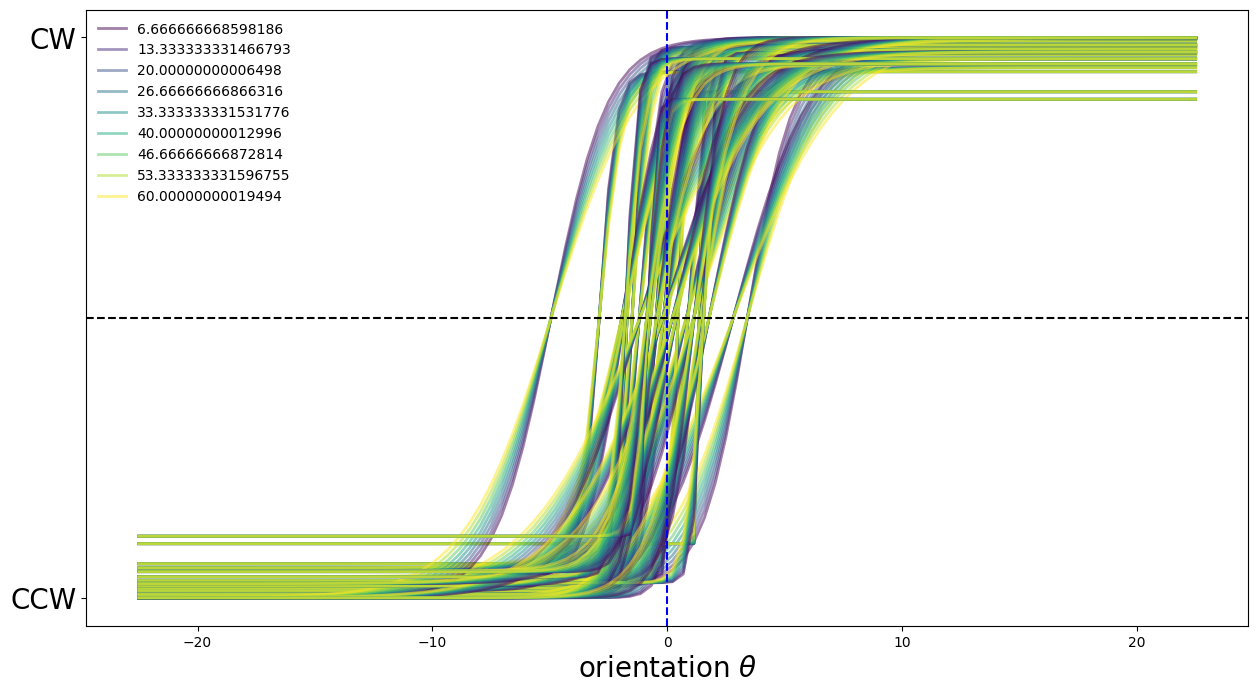

frozen_theta0=True
.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*
for apagrpwbxf, Loss = 4.930e-01 - theta0 = 0.00°, p0 = 2.72e-02, slope = 6.53e-01 + 1.06e+00 x B_theta
for w87npww874, Loss = 5.042e-01 - theta0 = 0.00°, p0 = 5.51e-02, slope = 1.92e+00 + 1.02e+00 x B_theta
for 64dtdq27os, Loss = 6.687e-01 - theta0 = 0.00°, p0 = 1.02e-01, slope = 1.14e+00 + 1.05e+00 x B_theta
for w2oz9j2a3v, Loss = 6.916e-01 - theta0 = 0.00°, p0 = 5.58e-02, slope = 7.28e-01 + 1.08e+00 x B_theta
for wsumnmxd8c, Loss = 4.070e-01 - theta0 = 0.00°, p0 = 2.31e-02, slope = 7.75e-01 + 1.04e+00 x B_theta
for rtumbda4hz, Loss = 6.190e-01 - theta0 = 0.00°, p0 = 1.34e-02, slope = 1.72e+00 + 1.05e+00 x B_theta
for ybaxemnk16, Loss = 4.259e-01 - theta0 = 0.00°, p0 = 6.74e-02, slope = 1.39e-01 + 1.08e+00 x B_theta
for 6l605rv4nn, Loss = 6.945e-01 - theta0 = 0.00°, p0 = 2.08e-01, slope = 1.71e-02 + 1.16e+00 x B_thet

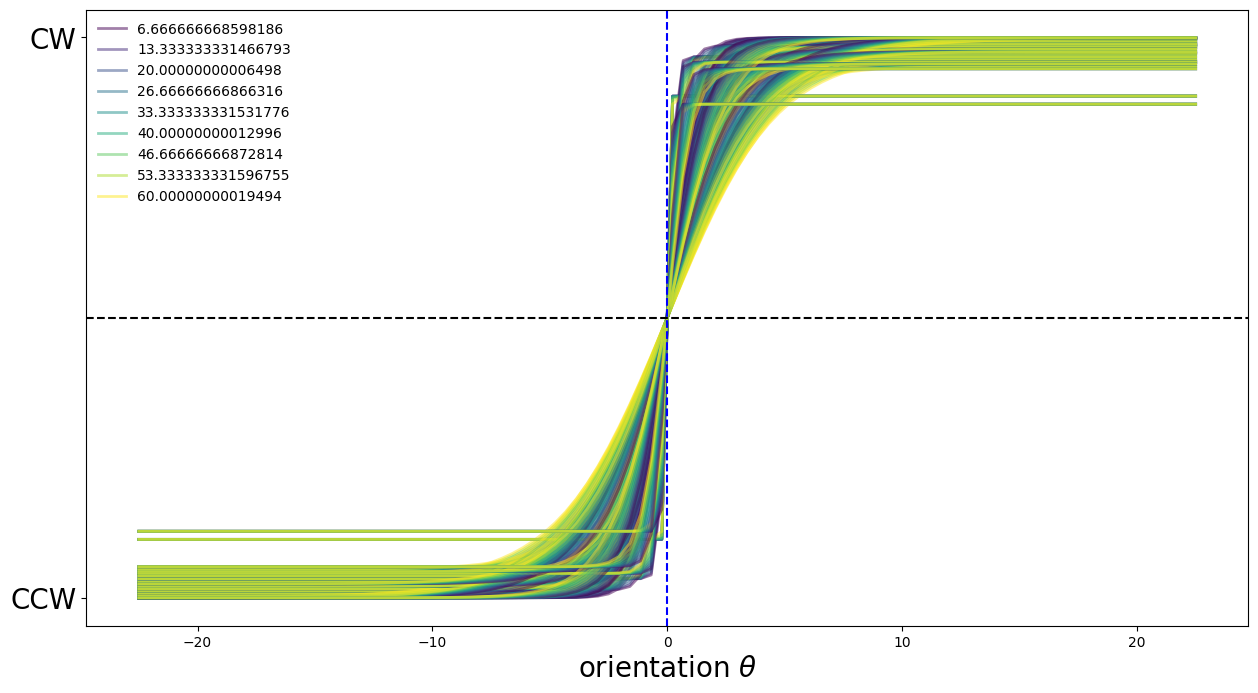

In [7]:
# for the plot
x_values = np.linspace(-theta_max, theta_max, 100)[:, None]
# Create a colormap
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(vmin=0, vmax=len(B_thetas) - 1)

for frozen_theta0 in [False, True]:

    print(f'{frozen_theta0=}')
    print(50*'.-*')
    
    fig, ax = plt.subplots(figsize=(15, 8))

    for session in responses.keys():    
        y = responses[session]

        logistic_model, loss = fit_data(theta_trials, B_theta_trials, y, frozen_theta0=frozen_theta0, verbose=False)

        print(f"for {session}, Loss = {loss:.3e} - theta0 = {logistic_model.theta0.item():.2f}°, p0 = {torch.sigmoid(logistic_model.logit0).item():.2e}, slope = {torch.exp(logistic_model.log_wt).item():.2e} + {torch.exp(logistic_model.log_wt_B_theta).item():.2e} x B_theta")

        for i_B_theta, B_theta in enumerate(B_thetas):
            y_values = logistic_model(torch.Tensor(x_values), (i_B_theta*torch.ones_like(torch.Tensor(x_values)).long())).detach().numpy()
            color = cmap(norm(i_B_theta))
            ax.plot(x_values, y_values, color=color, alpha=0.5, lw=2, label=f'{B_theta}' if session==list(responses.keys())[0] else None)

    ax.set_xlabel(r"orientation $\theta$", fontsize=20)
    ax.axhline(.5, color='k', linestyle='--')
    ax.axvline(0., color='b', linestyle='--')
    ax.set_yticks([0.0, 1.0])
    ax.set_yticklabels(["CCW", "CW"], fontsize=20)
    ax.legend(fontsize=10, frameon=False, scatterpoints=6);
    plt.show();


### optimize learning parameters with optuna

In [8]:
logistic_model, loss = fit_data(theta_trials, B_theta_trials, y, verbose=True)

Iteration: 0 - Loss: 5.548e-01
Iteration: 32 - Loss: 4.769e-01
Iteration: 64 - Loss: 4.737e-01
Iteration: 96 - Loss: 4.560e-01
Iteration: 128 - Loss: 4.520e-01
Iteration: 160 - Loss: 4.479e-01
Iteration: 192 - Loss: 4.495e-01
Iteration: 224 - Loss: 4.491e-01
Iteration: 256 - Loss: 4.499e-01
Iteration: 288 - Loss: 4.520e-01
Iteration: 320 - Loss: 4.539e-01
Iteration: 352 - Loss: 4.552e-01
Iteration: 384 - Loss: 4.521e-01
Iteration: 416 - Loss: 4.516e-01
Iteration: 448 - Loss: 4.545e-01
Iteration: 480 - Loss: 4.529e-01
Iteration: 512 - Loss: 4.515e-01
Iteration: 544 - Loss: 4.539e-01
Iteration: 576 - Loss: 4.519e-01
Iteration: 608 - Loss: 4.514e-01
Iteration: 640 - Loss: 4.533e-01
Iteration: 672 - Loss: 4.511e-01
Iteration: 704 - Loss: 4.523e-01
Iteration: 736 - Loss: 4.517e-01
Iteration: 768 - Loss: 4.509e-01
Iteration: 800 - Loss: 4.517e-01
Iteration: 832 - Loss: 4.499e-01
Iteration: 864 - Loss: 4.511e-01
Iteration: 896 - Loss: 4.495e-01
Iteration: 928 - Loss: 4.498e-01
Iteration: 960 

In [9]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_name = 'B_theta'
path_save_optuna = os.path.join('/tmp', f'optuna_{study_name}.sqlite3') # global name
%rm {path_save_optuna}

In [10]:
def objective(trial):
    vars = dict(verbose = False,  num_epochs=num_epochs//2)
    max_threshold = .999
    vars['batch_size'] = trial.suggest_int('batch_size', 2, 64, log=True, step=1)
    vars['optimizer'] = trial.suggest_categorical('optimizer', ['adamw', 'adam']) # 'adagrad', 'sparseadam', 'rmsprop', 'adadelta', 'sgd',
    scale = 10
    vars['learning_rate'] = trial.suggest_float('learning_rate', learning_rate / scale, learning_rate * scale, log=True)
    vars['weight_decay'] = trial.suggest_float('weight_decay', weight_decay / scale, weight_decay * scale, log=True)
    scale = 4
    vars['log_wt'] = trial.suggest_float('log_wt', log_wt - scale, log_wt + scale, log=False)
    vars['log_wt_B_theta'] = trial.suggest_float('log_wt_B_theta', log_wt - scale, log_wt + scale, log=False)
    vars['etab1'] = trial.suggest_float('etab1', etab1/scale, min(etab1*scale, max_threshold), log=True)
    vars['etab2'] = trial.suggest_float('etab2', etab2/scale, min(etab2*scale, max_threshold), log=True)
    vars['amsgrad'] = trial.suggest_categorical('amsgrad', [True, False])
    vars['logit0'] = trial.suggest_float('logit0', logit0 - scale, logit0 + scale, log=False)
    scale = 2
    # vars['theta0'] = trial.suggest_float('theta0', theta0 - scale, theta0 + scale, log=False)

    loss = 0
    for session in responses.keys():    
        y = responses[session]
        _, loss_ = fit_data(theta_trials, B_theta_trials, y, **vars)
        loss += loss_
    return loss/len(filenames_valid)


print(50*'=')
sampler = optuna.samplers.TPESampler(multivariate=True)
study = optuna.create_study(direction='minimize', load_if_exists=True, sampler=sampler, storage=f"sqlite:///{path_save_optuna}", study_name=study_name)
study.optimize(objective, n_trials=max((200-len(study.trials), 0)), n_jobs=1, show_progress_bar=True)
print(50*'=')

/Users/laurentperrinet/.venv/lib/python3.12/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

[W 2025-03-21 09:27:30,055] Trial 0 failed with parameters: {'batch_size': 3, 'optimizer': 'adam', 'learning_rate': 0.00037267360853263196, 'weight_decay': 0.006778015296798536, 'log_wt': 2.546458481175968, 'log_wt_B_theta': -1.0777835649431253, 'etab1': 0.008039680898593853, 'etab2': 2.258861988172649e-06, 'amsgrad': False, 'logit0': -2.735358465857578} because of the following error: RuntimeError('all elements of input should be between 0 and 1').
Traceback (most recent call last):
  File "/Users/laurentperrinet/.venv/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/3s/q2x8bxzj43g4rdvb2wjt67640000gq/T/ipykernel_63036/4009221191.py", line 22, in objective
    _, loss_ = fit_data(theta_trials, B_theta_trials, y, **vars)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/3s/q2x8bxzj43g4rdvb2wjt67640000gq/T/ipykernel_63036/1138527225.

RuntimeError: all elements of input should be between 0 and 1

In [ ]:
print(50*'-.')
print(f"Best params: {study.best_params}")
print(f"Best value: {study.best_value:.3f} at {now.strftime("%Y-%m-%d %H:%M:%S")}")
print(50*'-')